# Using the Hazard Modeller's Toolkit - Earthquake Catalogue Examples 

This notebook contains: 

1. Read a seismic catalogue and pre-defined seismic sources. 

2. Explore basic methods for qualitative analysis of the catalogue. 

3. Declustering: Aftershocks and foreshocks identification and removal. 

4. Completeness

5. Estimation of the Gutenberg-Richter parameters. 

6. Exploration of some methods to estimate the maximum magnitude (statistically from the catalogue)


### Importing the libraries and Dependencies

To use the toolkit features we need to import at the start of the session those tools that we are planning to use.

In [1]:
%load_ext autoreload
%autoreload 2
import warnings; warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline  

# Python dependences
import os
import numpy as np   # Numpy - Python's numerical library
import matplotlib.pyplot as plt  # Matplotlib - Python's plotting library
from copy import deepcopy   # Python module for copying objects

# Input and Output Tools
# Catalogue and sources 
from openquake.hmtk.parsers.catalogue import CsvCatalogueParser   # Reads an earthquake catalogue from CSV
from openquake.hmtk.parsers.catalogue.csv_catalogue_parser import CsvCatalogueWriter  # Writes an earthquake catalogue to CSV
from openquake.hmtk.parsers.source_model.nrml04_parser import nrmlSourceModelParser  # Imports a source model from XML

# Plotting tools
from openquake.hmtk.plotting.mapping import HMTKBaseMap
from openquake.hmtk.plotting.seismicity.completeness import plot_stepp_1972
from openquake.hmtk.plotting.seismicity.catalogue_plots import plot_magnitude_time_scatter
from openquake.hmtk.plotting.seismicity.catalogue_plots import plot_depth_histogram
from openquake.hmtk.plotting.seismicity.catalogue_plots import plot_magnitude_time_density
from openquake.hmtk.plotting.seismicity.max_magnitude.cumulative_moment import plot_cumulative_moment 
from openquake.hmtk.plotting.seismicity.occurrence.recurrence_plot import plot_recurrence_model
from openquake.hmtk.plotting.seismicity.catalogue_plots import (plot_observed_recurrence, 
                                                                get_completeness_adjusted_table,
                                                               _get_catalogue_bin_limits)

# Seismicity tools: Events and declustering methods
from openquake.hmtk.seismicity.selector import CatalogueSelector
from openquake.hmtk.seismicity.declusterer.dec_afteran import Afteran 
from openquake.hmtk.seismicity.declusterer.dec_gardner_knopoff import GardnerKnopoffType1 
from openquake.hmtk.seismicity.declusterer.distance_time_windows import (GardnerKnopoffWindow, 
                                                                         GruenthalWindow, 
                                                                         UhrhammerWindow)

# Completeness tools
from openquake.hmtk.seismicity.completeness.comp_stepp_1971 import Stepp1971

# Seismicity tools: Recurrence methods
from openquake.hazardlib.mfd import TruncatedGRMFD
from openquake.hmtk.seismicity.occurrence.aki_maximum_likelihood import AkiMaxLikelihood
from openquake.hmtk.seismicity.occurrence.b_maximum_likelihood import BMaxLikelihood
from openquake.hmtk.seismicity.occurrence.kijko_smit import KijkoSmit
from openquake.hmtk.seismicity.max_magnitude.kijko_sellevol_bayes import KijkoSellevolBayes
from openquake.hmtk.seismicity.occurrence.weichert import Weichert

# Seismicity tools: Recurrence methods
from openquake.hmtk.seismicity.max_magnitude.kijko_sellevol_fixed_b import KijkoSellevolFixedb
from openquake.hmtk.seismicity.max_magnitude.kijko_sellevol_bayes import KijkoSellevolBayes
from openquake.hmtk.seismicity.max_magnitude.kijko_nonparametric_gaussian import KijkoNonParametricGaussian
from openquake.hmtk.seismicity.max_magnitude.cumulative_moment_release import CumulativeMoment 

# Seismicity tools: Smoothed seismicity
from openquake.hmtk.seismicity.smoothing.smoothed_seismicity import SmoothedSeismicity 
from openquake.hmtk.seismicity.smoothing.kernels.isotropic_gaussian import IsotropicGaussian 

print "Everything Imported OK!"

Everything Imported OK!


### Importing the Catalogue (+ Useful Methods!)

Seismic catalogue format

The hmtk is able to read a catalogue in .csv format (Windows comma separated values). 
There are a minimum number of fields that are required to import and use the catalogue 
information into hmtk. 
The fields require: 

        eventID* Agency year* month* day* hour* minute* second* longitude* latitude* depth* magnitude*

The fields marked with a star are mandatory.



In [3]:
#Importing catalogue
catalogue_filename = 'input_data/Aegean_ExtendedCat1.csv'
parser = CsvCatalogueParser(catalogue_filename) # From .csv to hmtk

# Read and process the catalogue content in a variable called "catalogue"
catalogue = parser.read_file(start_year=1900, end_year=2012)

# How many events in the catalogue?
print "The catalogue contains %g events" % catalogue.get_number_events()

# What is the geographical extent of the catalogue?
bbox = catalogue.get_bounding_box()
print "Catalogue ranges from %.4f E to %.4f E Longitude and %.4f N to %.4f N Latitude\n" % bbox

Catalogue Attribute Identifier is not a recognised catalogue key
The catalogue contains 16401 events
Catalogue ranges from 18.5739 E to 32.0796 E Longitude and 32.7480 N to 42.5912 N Latitude



It is generally a good idea for the catalogue to be input in chronological order.

If the catalogue is not in chronological order then the following re-sorts the catalogue in-place to ensure it is in order



In [4]:
catalogue.sort_catalogue_chronologically()

### Visualising the catalogue

#### Magnitude - Time Density

To see how the distribution of magnitudes changes with time we can simply plot magnitude against time:

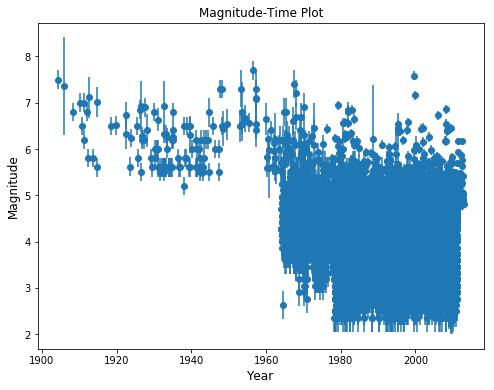

In [5]:
plot_magnitude_time_scatter(catalogue, plot_error=True)

Or, more informatively, plot the density of events with time

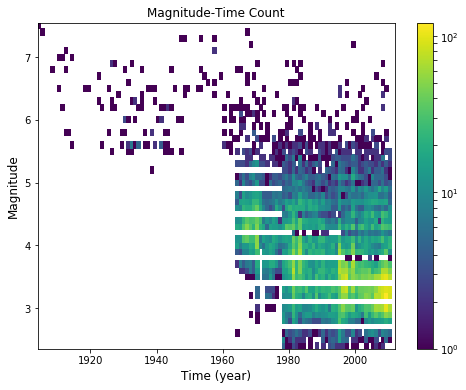

In [6]:
magnitude_bin_width = 0.1  # In magnitude units
time_bin_width = 1.0 # In years
plot_magnitude_time_density(catalogue, magnitude_bin_width, time_bin_width)

### View the Depth Distribution

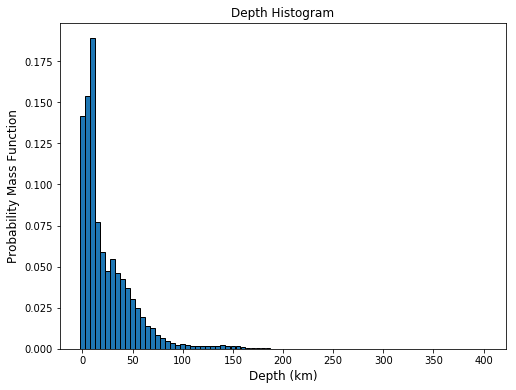

In [7]:
# Shows depth histogram every 5 km  
plot_depth_histogram(catalogue, 5., normalisation=True)

### Mapping the Catalogue

We can map the catalogue using the HMTK's mapping functions. A 'basemap' can support multiple layers:

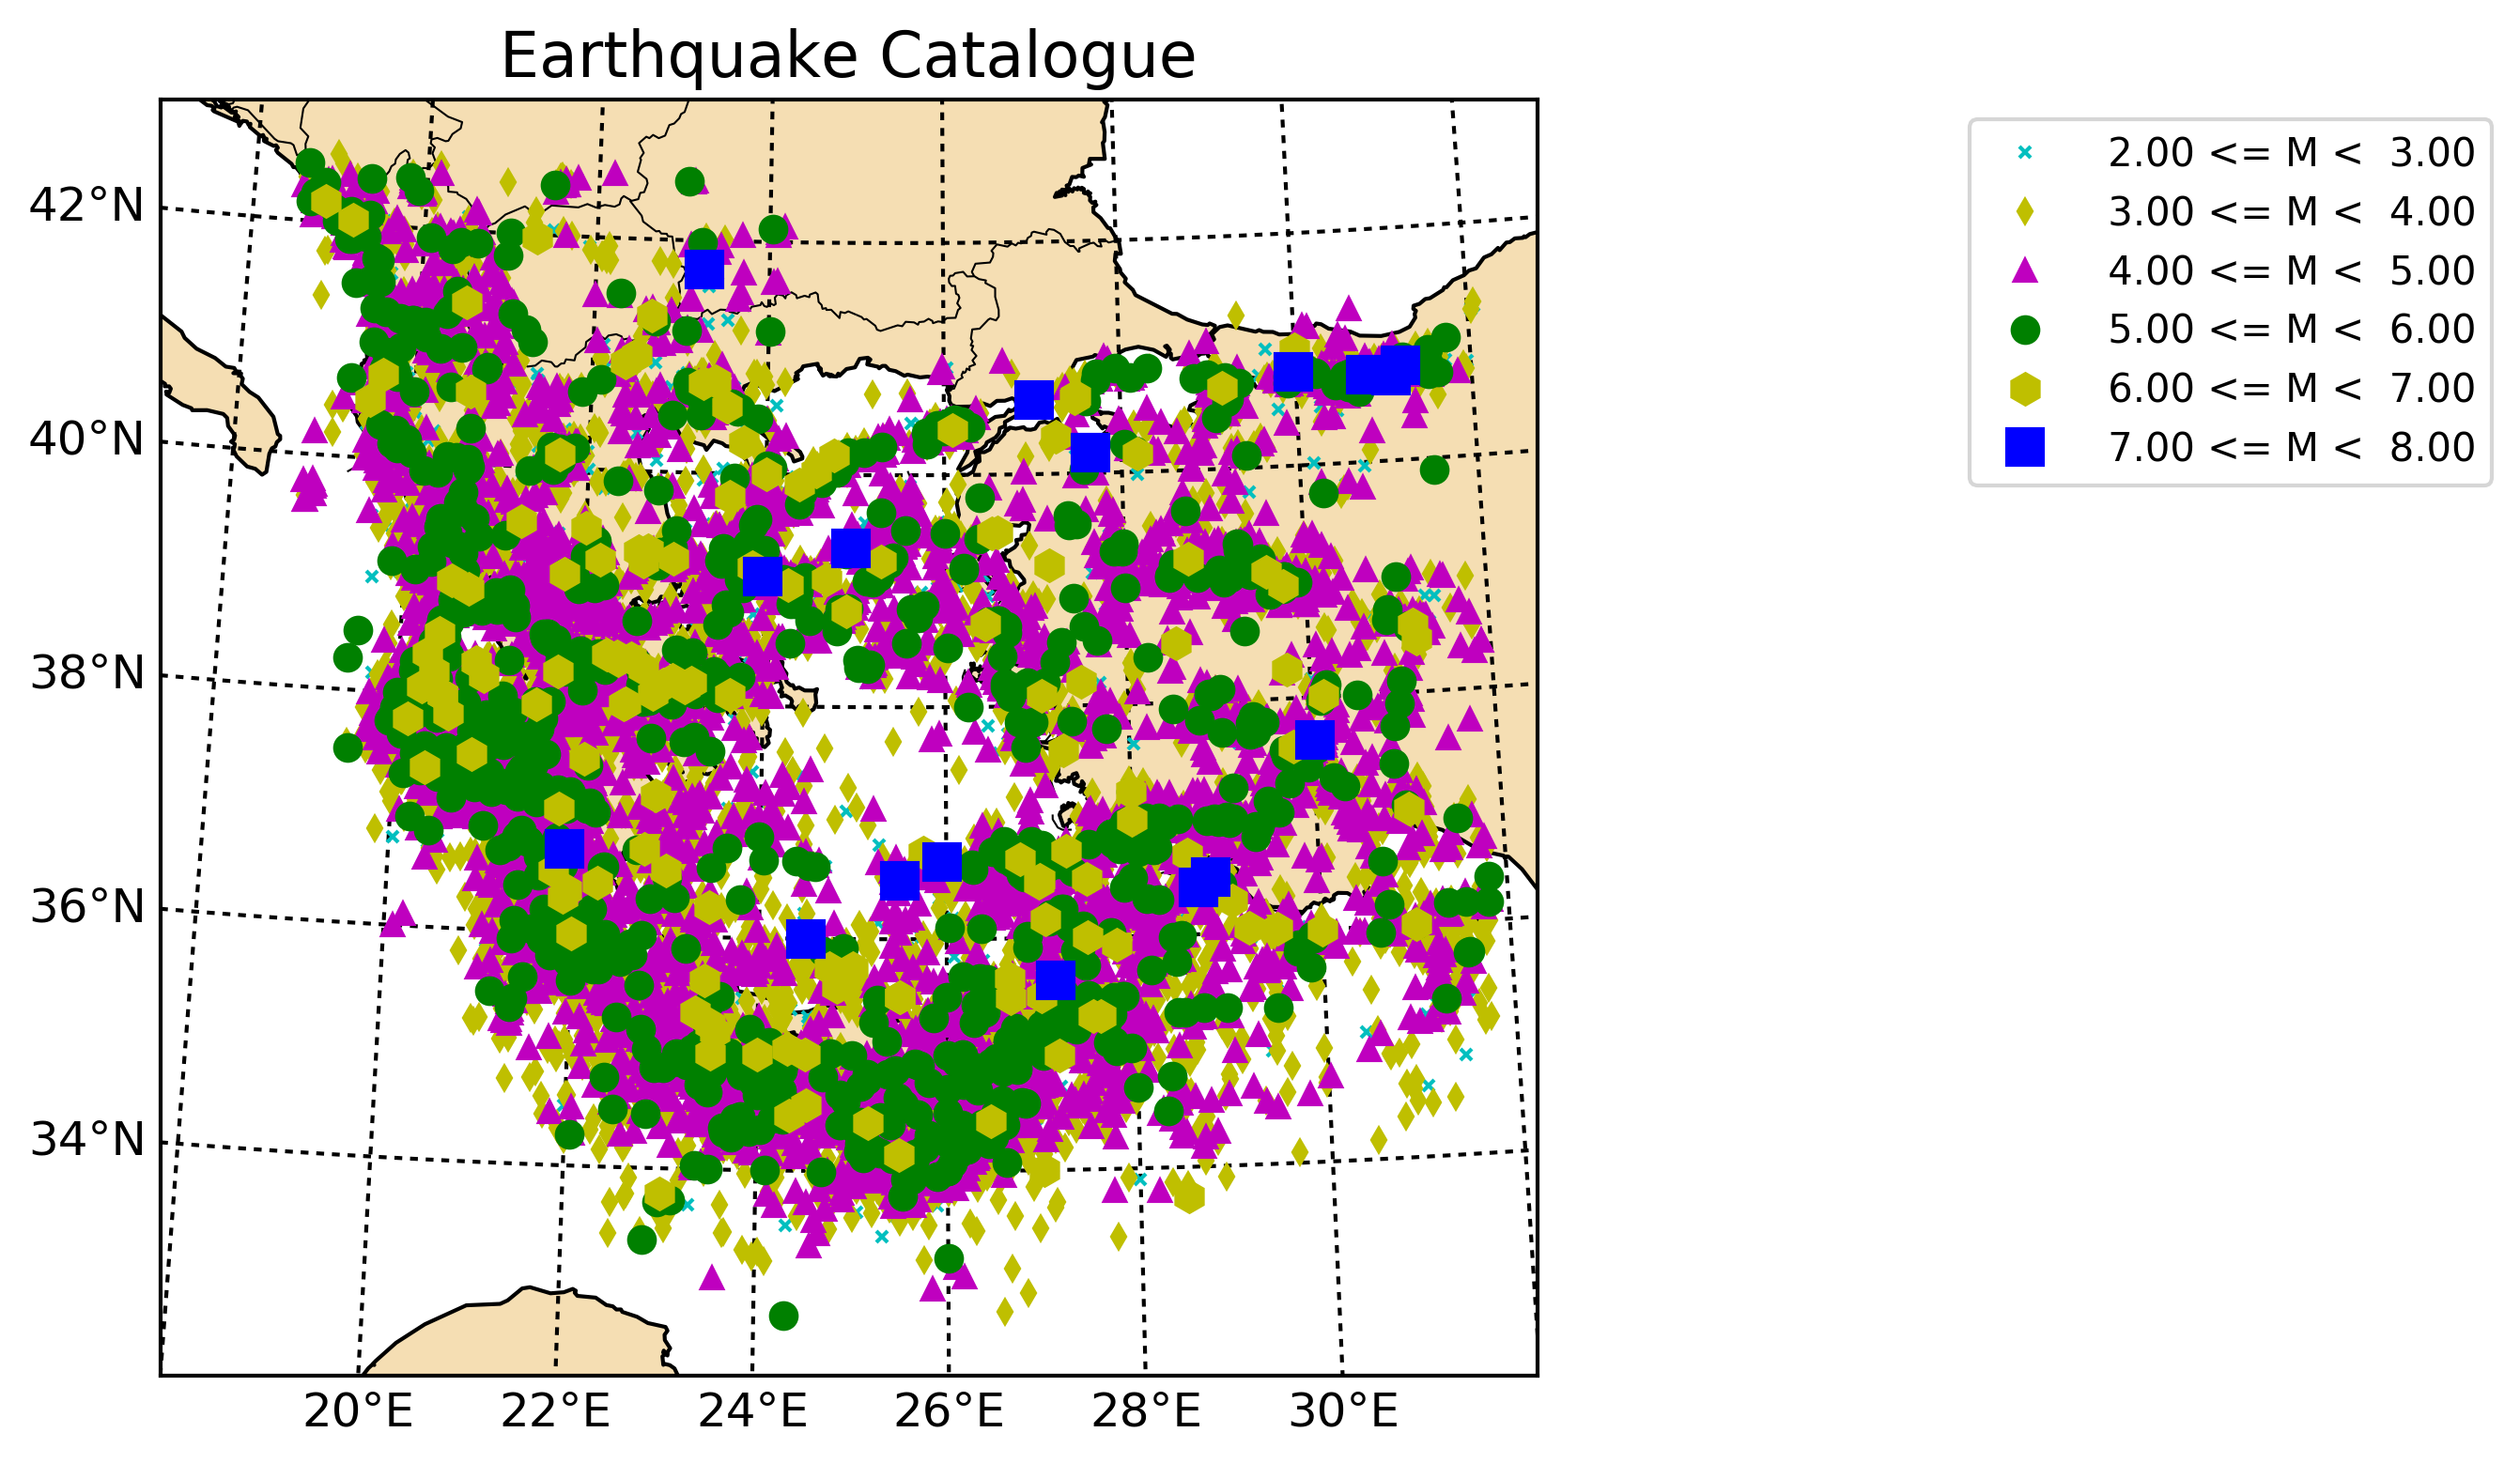

In [8]:
# Map configuration
llon, ulon, llat, ulat = catalogue.get_bounding_box()
map_config = {'min_lon': np.floor(llon), 'max_lon': np.ceil(ulon),
              'min_lat': np.floor(llat), 'max_lat': np.ceil(ulat), 'resolution':'i'}

# Creating a basemap - input a cconfiguration and (if desired) a title
basemap1 = HMTKBaseMap(map_config, 'Earthquake Catalogue')


# Adding the catalogue to the basemap
# In this case we will 'close' the figure after rendering, we do this by setting 'overlay=False'
# This is also the default option
# If we wanted to add another layer on top, we would set the overlay to True
basemap1.add_catalogue(catalogue, overlay=False)

### Declustering

The HMTK supports several methods for declustering the earthquake catalogue:

1. Gardner & Knopoff (1974)

2. AFTERAN (Musson, 1999)

Others will (eventually) be added in the future

We illustrate the use of the Gardner & Knopoff Algorithm

#### Configuring the algorithm

In [9]:
# Create an `instance' of the tool
declust_method = GardnerKnopoffType1()

# Create a configuration file
declust_config = {"time_distance_window": GardnerKnopoffWindow(), "fs_time_prop": 1.0}

### Running the algorithm

All declustering algorithms produce two outputs:

* cluster_index = Vector indicating the number of the cluster to which the earthquake belongs (including mainshock)
* cluster_flag = Vector indicating if the event is a foreshock (-1), mainshock (0) or aftershock (1)

In [10]:
cluster_index, cluster_flag = declust_method.decluster(catalogue, declust_config)

data = np.column_stack([catalogue.get_decimal_time(),
                        catalogue.data['magnitude'],
                        catalogue.data['longitude'],
                        catalogue.data['latitude'], cluster_index, cluster_flag])
print '      Time    Magnitude    Long.    Lat.   Cluster No. Index (-1 = foreshock, 0 = mainshock, 1 = afterschock)'
for row in data:
    print '%14.8f  %6.2f  %8.3f  %8.3f  %6.0f  %6.0f' %(row[0], row[1], row[2], row[3], row[4], row[5])

      Time    Magnitude    Long.    Lat.   Cluster No. Index (-1 = foreshock, 0 = mainshock, 1 = afterschock)
 1904.25801837    7.50    23.250    41.750       0       0
 1905.85457799    7.36    23.974    39.114       0       0
 1908.37574169    6.80    24.000    35.000       0       0
 1910.13209532    7.00    24.500    36.000       0       0
 1910.63746480    6.50    27.000    34.000       0       0
 1911.25659037    7.00    25.500    36.500       0       0
 1911.32839136    6.20    30.000    36.000       0       0
 1912.06470685    6.80    20.500    38.000       0       0
 1912.30360827    5.80    19.500    37.500       0       0
 1912.60399416    7.12    27.023    40.638       0       0
 1913.74606887    5.80    24.000    35.000       0       0
 1914.75594966    7.02    30.021    37.629       0       0
 1914.79250856    5.60    23.500    38.250       0       0
 1918.53927657    6.50    25.500    35.500       0       0
 1919.88195380    6.51    26.530    39.498       0       0
 1922

### Purging non-Poissonian Events from the Catalogue

Having run the declustering algorithm you may want to remove all of the 'non-Poissonian' events (i.e. foreshocks and aftershocks) from the catalogue

In [11]:
# Copying the catalogue and saving it under a new name "catalogue_dec"(declustered catalogue) 
catalogue_dec = deepcopy(catalogue)

# Logical indexing: Chossing the outputs for the main events: Cluster_flag = 0 
mainshock_flag = cluster_flag == 0 

# Filtering the foreshocks and aftershocks in the copy of the catalogue 
catalogue_dec.purge_catalogue(mainshock_flag)


# Printing the number of events considered main shocks
print 'Declustering: ok'
print "Number of events in original catalogue: %g" % catalogue.get_number_events()
print 'Number of mainshocks: %g' % catalogue_dec.get_number_events()

Declustering: ok
Number of events in original catalogue: 16401
Number of mainshocks: 5754


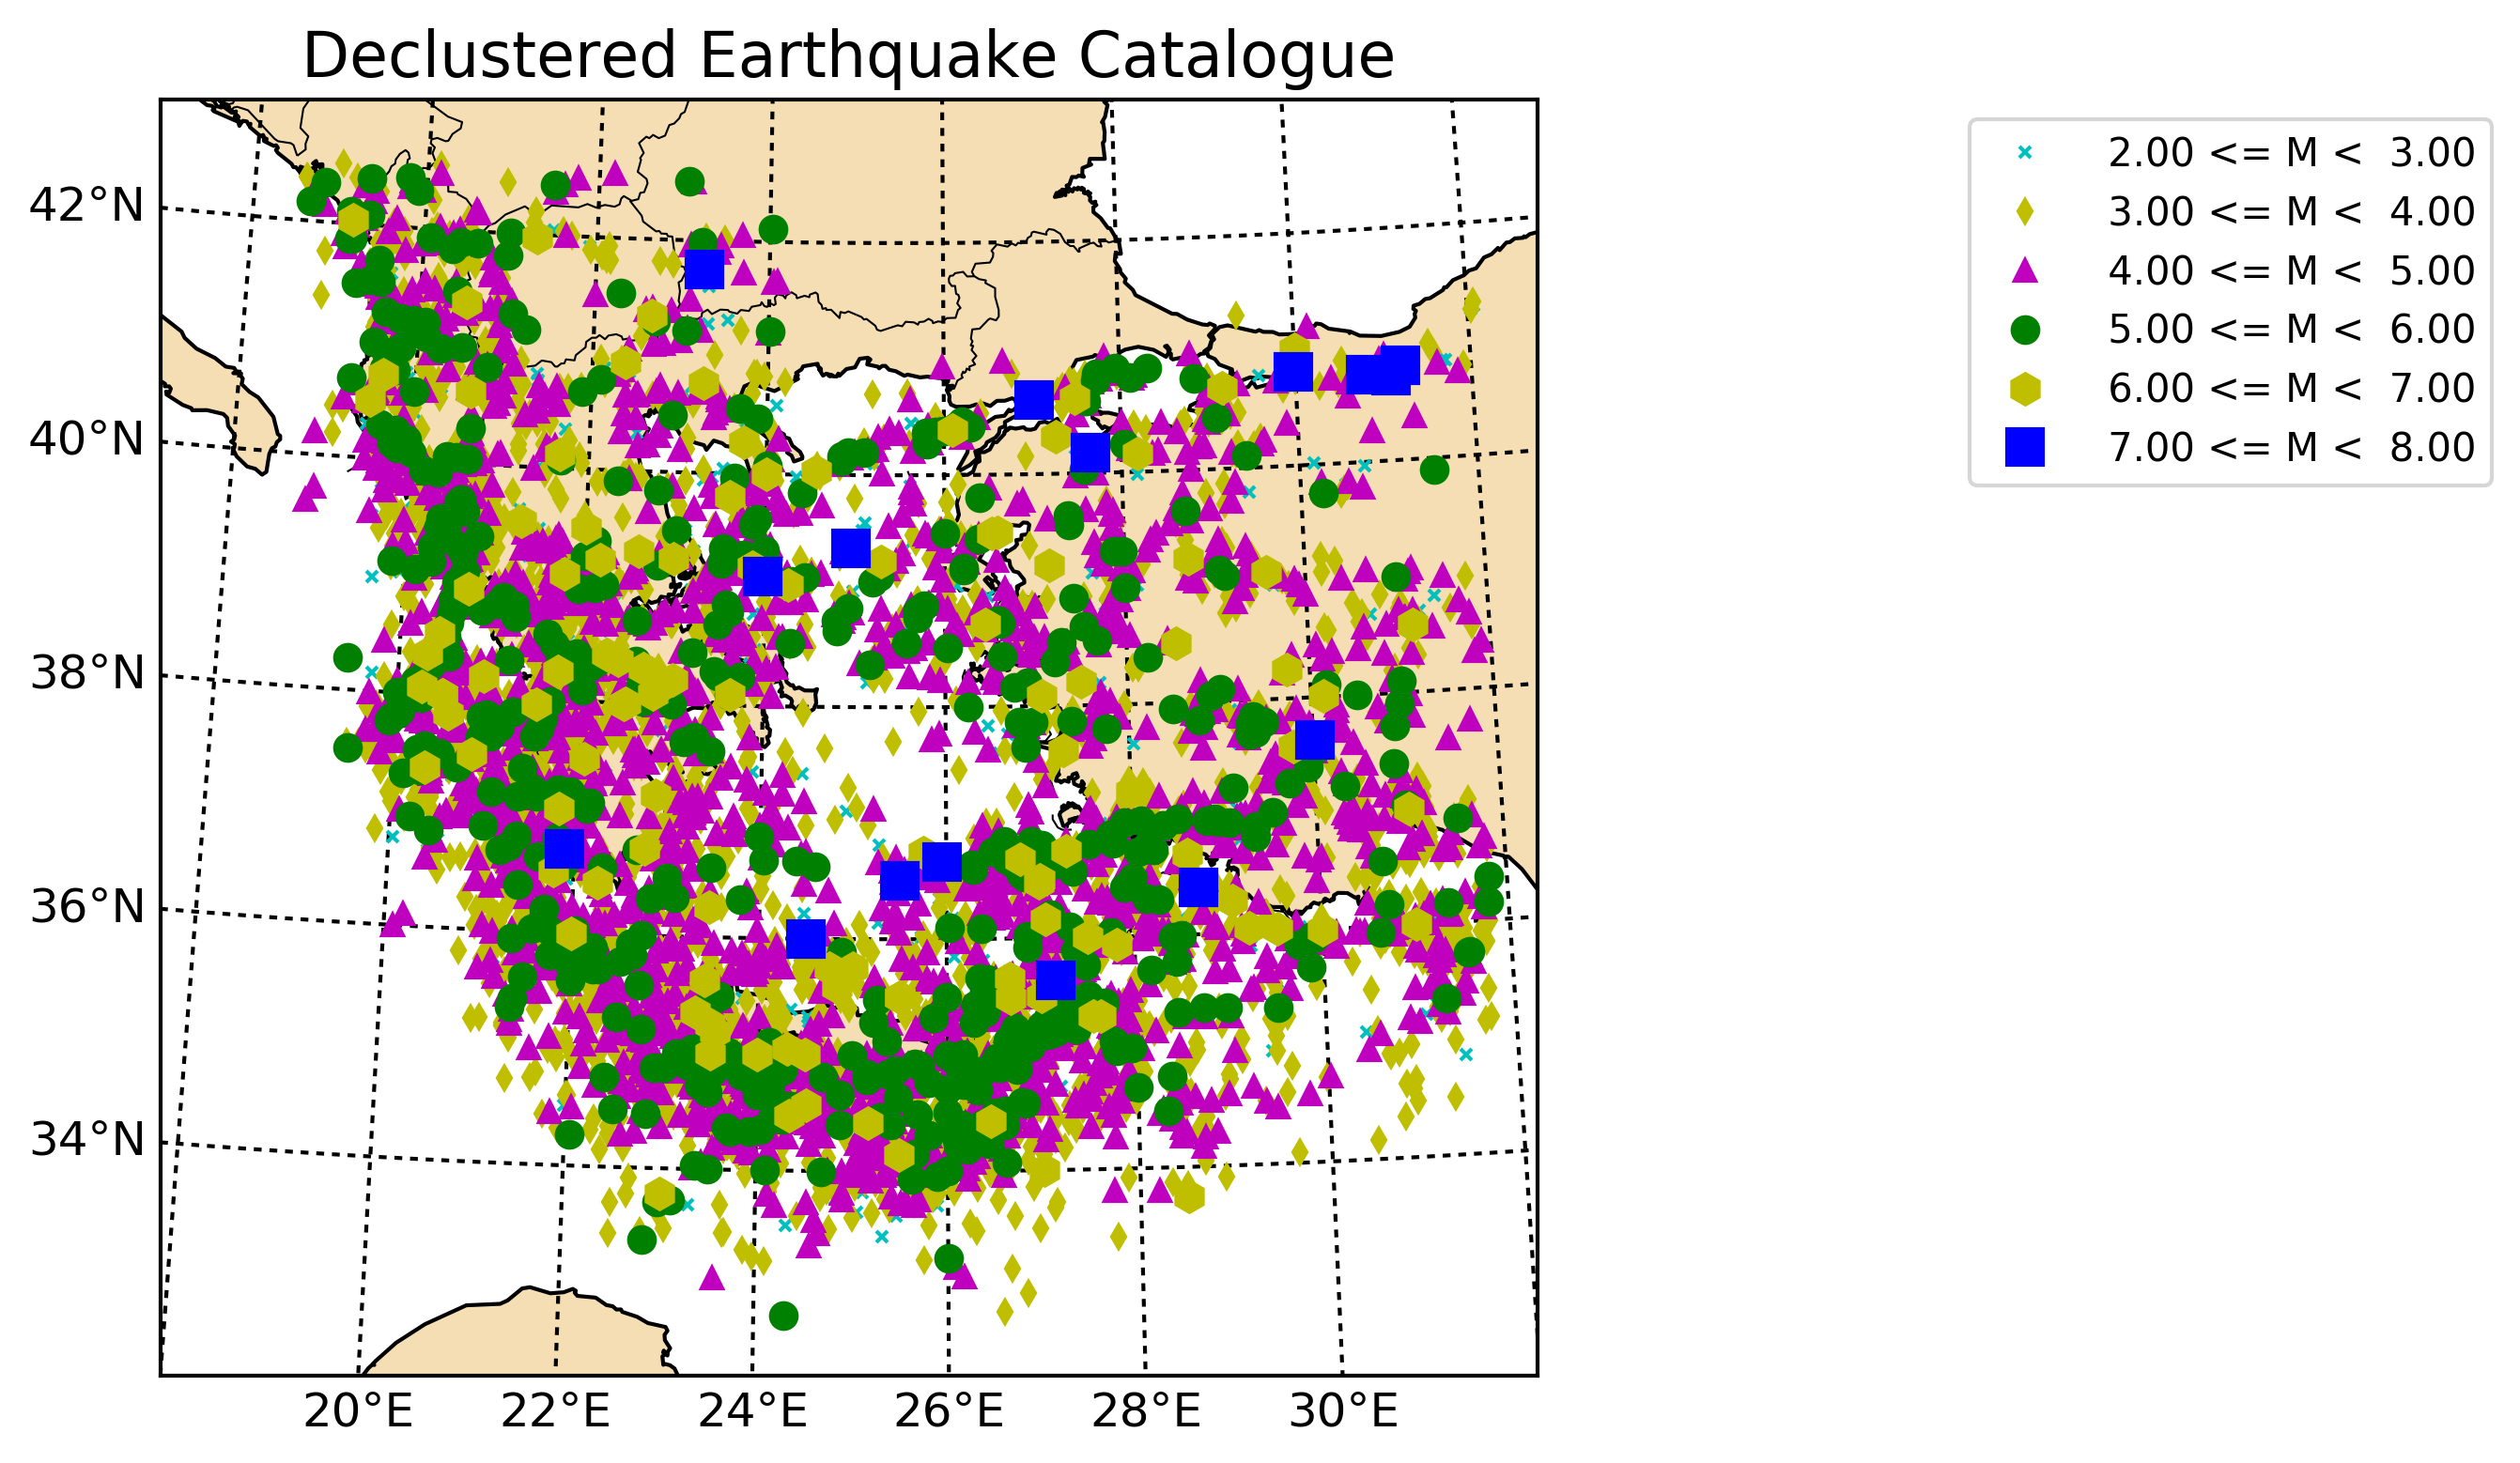

In [12]:
basemap1 = HMTKBaseMap(map_config, 'Declustered Earthquake Catalogue')
basemap1.add_catalogue(catalogue_dec, overlay=False)

### Saving the catalogue

In [13]:
# Selecting path and name for the output file 
output_cat_dec = 'output_data/aegean_cat_dec.csv'

if os.path.exists(output_cat_dec):
    os.remove(output_cat_dec)

# Call the method and save the output file under the name "cat_csv"
cat_csv = CsvCatalogueWriter(output_cat_dec) 

# Write the purged catalogue
cat_csv.write_file(catalogue_dec)
print "Catalogue successfully written to %s" % output_cat_dec

Catalogue successfully written to output_data/aegean_cat_dec.csv


### Analysis of Completeness

In [ ]:
# Set up the configuration parameters
comp_config = {'magnitude_bin': 0.5, 'time_bin': 5.0, 'increment_lock': True}

# Calling the method
completeness_algorithm = Stepp1971()

# Use the catalogue and completeness configuration
completeness_table = completeness_algorithm.completeness(catalogue_dec, comp_config)
print 'Completeness: ok'

# Print the completeness table
print '\n'
print 'Completeness table using Stepp method (1971)'
print completeness_table
print '\n'

# Setting configuration for the completeness plot
completeness_parameters = completeness_algorithm
output_file = "output_data/Stepp_aegean.png"
if os.path.exists(output_file):
    os.remove(output_file)
plot_stepp_1972.create_stepp_plot(completeness_parameters, output_file)

Completeness: ok


Completeness table using Stepp method (1971)
[[ 1970.      2. ]
 [ 1970.      2.5]
 [ 1970.      3. ]
 [ 1970.      3.5]
 [ 1966.      4. ]
 [ 1965.      4.5]
 [ 1965.      5. ]
 [ 1965.      5.5]
 [ 1928.      6. ]
 [ 1899.      6.5]
 [ 1896.      7. ]]




### Manual setup of the completeness table

The hmtk allows to use a completeness table proposed by the modeller. 

(2012.0, 4.5)
(2000.0, 4.5)
(1964.0, 5.0)
(1960.0, 5.5)
(1900.0, 6.5)
(1904.0, 6.5)


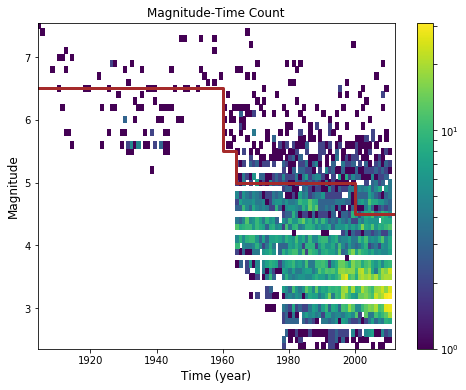

In [15]:
# Table format
completeness_table_a = np.array([[2000., 4.5],
                                 [1964., 5.0],
                                 [1960., 5.5],
                                 [1900., 6.5]])

plot_magnitude_time_density(catalogue_dec, 0.1, 1.0,
                            completeness=completeness_table_a)

# Estimating Recurrence

Several methods are available for estimating recurrence taking into account time-dependent completeness

1. 'Weighted' Maximum Likelihood
2. Kijko & Smit (2012)
3. Weichert (1980)
4. Penalized Maximum Likelihood (Johnston et al., 1994)

In [16]:
recurrence_estimator = Weichert()

recurrence_config = {"magnitude_interval": 0.1}

bval, sigma_b, aval, sigma_a = recurrence_estimator.calculate(catalogue_dec,
                                                              recurrence_config,
                                                              completeness_table_a)

print "a = %.3f (+/- %.3f),  b = %.3f (+/-%.3f)" % (aval, sigma_a, bval, sigma_b)

a = 5.377 (+/- 0.015),  b = 0.867 (+/-0.024)


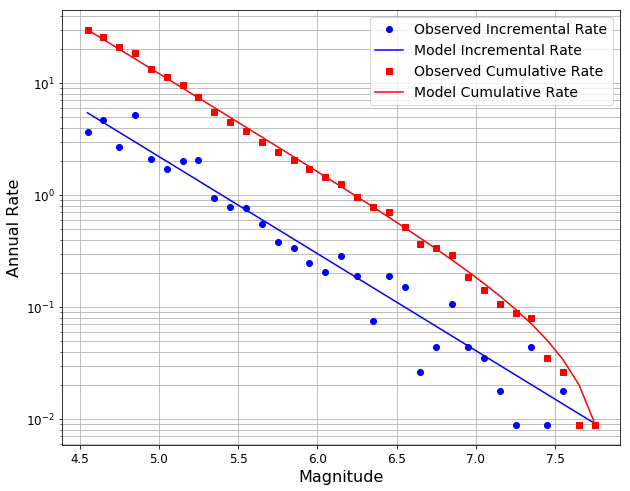

In [17]:
mfd0 = TruncatedGRMFD(4.5, 7.8, 0.1, aval, bval)
plot_recurrence_model(mfd0, catalogue_dec, completeness_table_a, 0.1)

### Inferring Maximum Magnitude

The toolkit contains several tools for making statistical inferences on the maximum magnitude using the earthquake catalogue.

Three of these are based on the methods proposed by Kijko (2004):

1. KijkoSellevolFixedb - Maximum likelihood estimator of $M_{MAX}$ assuming no uncertainty in the b-value

2. KijkoSellevolBayes - Maximum likelihood estimator of $M_{MAX}$ assuming an uncertain b-value

3. KijkoNonParametricGaussian -Maximum likelihood estimator of $M_{MAX}$ assuming no specific magnitude frequency distribution

More details are given in the HMTK manual.

An additional method - based on cumulative moment release (adaptation of Makropolous & Burton (1983)) is also included



#### Example: Kijko-Sellevol-Bayes Approach

In [18]:
# Create the configuration
mmax_config = {
    "input_mmin": 5.0,
    "input_mmax": None,   # It will take the maximum observed in the catalogue
    "input_mmax_uncertainty": None,  # It will take the uncertainty of the maximum observed in the catalogue
    "b-value": bval,
    "sigma-b": sigma_b
}

# Instantiate the tool
mmax_estimator = KijkoSellevolBayes()
# Execute!
mmax, sigma_mmax = mmax_estimator.get_mmax(catalogue_dec, mmax_config)
print "Maximum Magnitude (Estimated - KSB): %.3f +/- %.3f" % (mmax, sigma_mmax)

Maximum Magnitude (Estimated - KSB): 7.870 +/- 0.263


#### Example: Kijko-Sellevol Fixed-b Approach

In [19]:
mmax_estimator2 = KijkoSellevolFixedb()
mmax2, sigma_mmax2 = mmax_estimator2.get_mmax(catalogue_dec, mmax_config)
print "Maximum Magnitude (Estimated - K-S-fixed-b): %.3f +/- %.3f" % (mmax2, sigma_mmax2)

(5.0, array(7.7), 658.0, 1.9956322345932438)
Maximum Magnitude (Estimated - K-S-fixed-b): 7.872 +/- 0.263


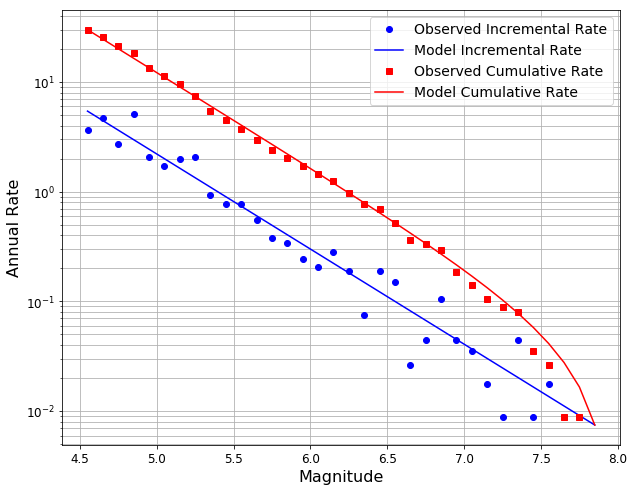

In [20]:
mfd0 = TruncatedGRMFD(4.5, mmax, 0.1, aval, bval)
plot_recurrence_model(mfd0, catalogue_dec, completeness_table_a, 0.1)

#### Example: Cumulative Moment Approach 

Maximum Magnitude (Cumulative Moment): 8.203 +/- 0.351


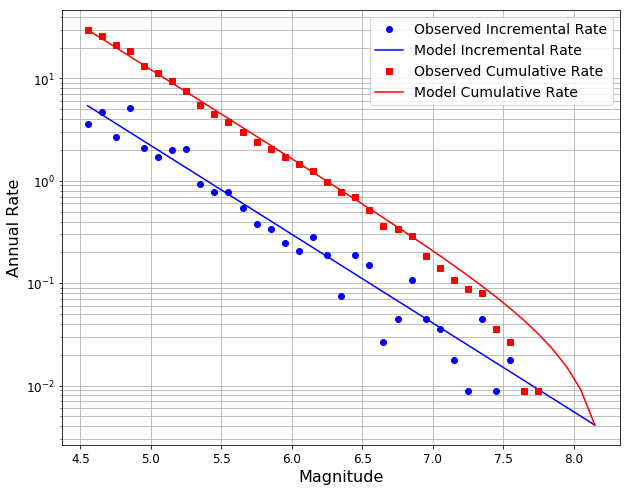

In [21]:
mmax_cm_config = {"number_bootstraps": 100}

mmax_estimator3 = CumulativeMoment()
mmax3, sigma_mmax3 = mmax_estimator3.get_mmax(catalogue_dec, mmax_cm_config)

print "Maximum Magnitude (Cumulative Moment): %.3f +/- %.3f" % (mmax3, sigma_mmax3)

mfd0 = TruncatedGRMFD(4.5, mmax3, 0.1, aval, bval)
plot_recurrence_model(mfd0, catalogue_dec, completeness_table_a, 0.1)

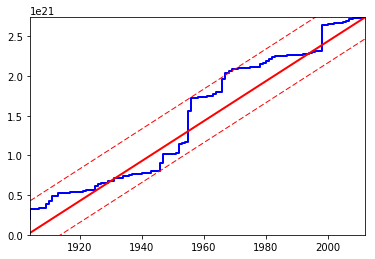

In [22]:
plot_cumulative_moment(catalogue_dec.data["year"], catalogue_dec.data["magnitude"])